In [1]:
# pip instal gama
import pandas as pd
import numpy as np

In [2]:
# Функция Отклонение (лет) от критического возраста: critical_age_l - младше порога; critical_age_h - старше порога

critical_age_threshold = 40  # принятый порог критического возраста

def critical_age(df,tr_age=critical_age_threshold):
    if 'age' in df.columns and 'int' in df.age.dtype.name:
        df['critical_age_l']=df['age'].apply(lambda x: tr_age - x if x < tr_age else 0 ).astype('int8')
        df['critical_age_h']=df['age'].apply(lambda x: x - tr_age if x > tr_age else 0  ).astype('int8')
    return df

In [3]:
df = pd.read_excel('short_data_for_model.xlsx')
df = df.dropna()
df = critical_age(df,tr_age=40)
df['trend'] = df['INR(MHO)'] - df['prev_INR(MHO)']
df.head()

,id,gender,age,dose,prev_INR(MHO),atrial_fibrillation,mitral_valve,aortal_valve,date_diff,INR(MHO),sample,pass_dose,institution_id,critical_age_l,critical_age_h,trend
0,140361892057136,0,57,7.50,3.11,1,0,0,13.0,3.32,1,0,20,0,17,0.21
1,140361892057136,0,57,7.50,3.32,1,0,0,15.0,2.01,2,0,20,0,17,-1.31
2,140361892057264,1,50,5.00,2.01,0,1,0,26.0,2.75,1,0,20,0,10,0.74
3,140361892057392,0,53,6.25,1.42,1,0,0,15.0,2.56,1,0,20,0,13,1.14
4,140361892057392,0,53,6.25,2.56,1,0,0,49.0,2.80,2,0,20,0,13,0.24


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from gama import GamaRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import logging

## Вспомогательные подпрограммы

In [5]:

RANDOM_STATE = 0
MAX_TIME = 180
JOBS = 5

In [6]:
def simplified_stratified_split(df, target_column='dose', *, n_bins=4, test_size=0.2, random_state=42):
    """
    Функция разбивает датафрейм на обучающий и тестовый наборы с учетом стратификации по квантильным значениям целевой переменной.

    Параметры:
    - df (pd.DataFrame): исходный датафрейм
    - target_column (str): имя целевого столбца, по которому будет осуществляться стратификация
    - n_bins (int): количество интервалов для разделения квантильных значений целевой переменной
    - test_size (float): доля данных, которая будет использоваться для тестового набора
    - random_state (int): seed для случайности при разбиении

    Возвращает:
    - train_df (pd.DataFrame): обучающий датафрейм
    - test_df (pd.DataFrame): тестовый датафрейм
    """

    # 1. Классификация значений целевой переменной (target_column) по квантилям
    binned_target= pd.qcut(df[target_column], q=n_bins, labels=False, duplicates='drop')

    # 2. Разбивка индексов датафрейма на обучающую и тестовую выборки с учетом стратификации по квантильным интервалам целевой переменной
    train_idx, test_idx = train_test_split(df.index, test_size=test_size, stratify=binned_target, random_state=random_state)

    # 3. Разбиение исходного датафрейма на обучающий и тестовый наборы на основе полученных индексов
    train_df = df.loc[train_idx]
    test_df = df.loc[test_idx]

    return train_df, test_df

In [7]:
def estimateG(predictions, y_test):
    # Рассчитываем основные метрики
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    mape_value = np.mean(np.abs((y_test - predictions) / y_test)) * 100
    abs_diff = abs(y_test - predictions)
    diff_below_threshold = (abs_diff <= 0.5).sum()
    total_predictions = len(predictions)
    percentage_diff = (diff_below_threshold / total_predictions) * 100

    # Выводим результаты
    print("{:<55} {:>5.2f}".format("Средняя абсолютная ошибка (MAE):", mae))
    print("{:<55} {:>5.2f}".format("Среднеквадратичная ошибка (MSE):", mse))
    print("{:<55} {:>5.2f}".format("Коэффициент детерминации (R^2):", r2))
    print("{:<55} {:>5.2f}%".format("Средняя абсолютная процентная ошибка (MAPE):", mape_value))
    print("{:<55} {:>5.2f}%".format("Доля предсказаний с отклонением не более 0,5 мг:", percentage_diff))
    
    ae = round(abs(y_test - predictions)/0.5)
    col = ae
    size = ae*10
    plt.scatter(y_test, predictions, marker='o', c=col,  s=size)
    plt.title('Сравнение предсказанной и назначенной доз')
    
    plt.ylabel('Предсказанная доза')
    plt.xlabel('Назначенная доза');
    plt.grid()
    plt.show()
    return (mae, mse, r2, mape_value, percentage_diff)

In [8]:
def pipe_select(train_df, test_df, BaseSearch=None,
               scoring=('neg_mean_squared_error','r2'),regularize_length=True,
               verbose=logging.WARNING, preset='simple'): 
    X_train = train_df.drop('dose', axis=1)
    y_train = train_df['dose']
    X_test = test_df.drop('dose', axis=1)
    y_test = test_df['dose']

    gama = GamaRegressor(search=BaseSearch, max_total_time=MAX_TIME, 
                         scoring=scoring,                      
                         random_state=RANDOM_STATE, 
                         regularize_length=regularize_length,
                         # store="logs",
                         preset=preset,
                         n_jobs=JOBS, verbosity=verbose)

    print(f"Задание завершится приблизительно через {MAX_TIME / 60} мин.")
    gama.fit(X_train, y_train)
    print(gama.score(X_test, y_test))

    print(f"pipeline:\n{gama.export_script(f'gama_EA{MAX_TIME}.py')}\n")
    gama.export_script()
    
    predictions = gama.predict(X_test)

    scores = estimateG(predictions, y_test)
    return scores, gama

## Влияние стратификации 

In [9]:
def plot_split_hist(train,test, bins=4):
    yhist, ybins = np.histogram(test, bins=bins, range=None)
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    phist, pbins = np.histogram(train, bins=bins, range=None)
    pbins = 0.5 * (pbins[1:] + pbins[:-1])

    plt.plot(ybins,yhist, label='Test')
    plt.bar(pbins,phist, label='Train')
    plt.title('Распределение частей таргета')
    plt.xlabel('таргет')
    plt.ylabel('Количество')
    plt.legend()
    plt.tight_layout()
    plt.show()

Без стратификации


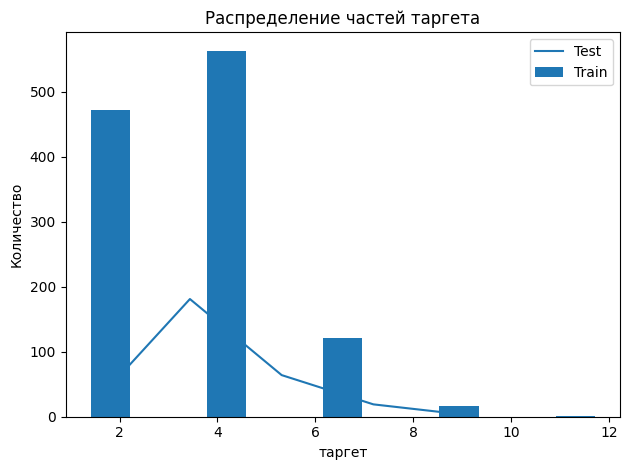

Со стратификацией


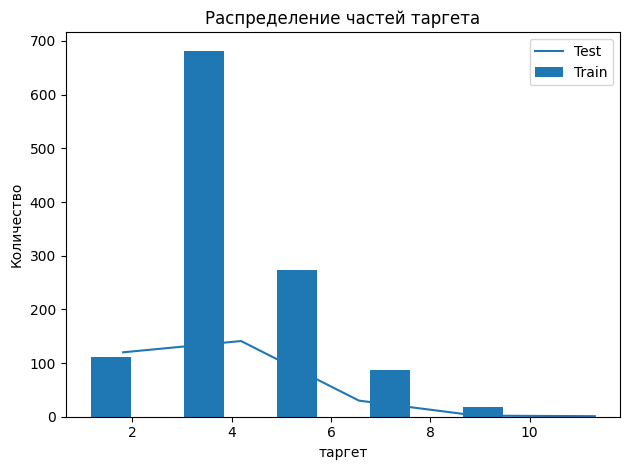

In [10]:
# Без стратификации
RANDOM_STATE = 0
BINS = 5
train_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)  #shuffle=False, 

y_train = train_df['dose']
y_test = test_df['dose']

print('Без стратификации')
plot_split_hist(y_train, y_test, bins=BINS)

# Со стратификацией

train_df, test_df = simplified_stratified_split(df, target_column='dose', n_bins=BINS, 
                                                test_size=0.2, random_state=RANDOM_STATE)

y_train = train_df['dose']
y_test = test_df['dose']

print('Со стратификацией')
plot_split_hist(y_train, y_test, bins=BINS)


## Генетический (эволюционный) поиск

In [9]:
from gama.search_methods import AsyncEA

RANDOM_STATE = 0
MAX_TIME = 600
JOBS = 5

Задание завершится приблизительно через 10.0 мин.
0.7060478198211463
pipeline:
from sklearn.impute import SimpleImputer
from category_encoders.target_encoder import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.kernel_approximation import Nystroem
from category_encoders.ordinal import OrdinalEncoder
from sklearn.neighbors import KNeighborsRegressor
from numpy import nan
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('ord-enc', OrdinalEncoder(cols=[], drop_invariant=True)),
('oh-enc', OneHotEncoder(cols=[])),
('target_enc', TargetEncoder(cols=[])),
('imputation', SimpleImputer(strategy='median')),
('1', Nystroem(gamma=0.15000000000000002, kernel='poly', n_components=2)),
('0', KNeighborsRegressor(n_neighbors=98, p=2, weights='distance'))])


Средняя абсолютная ошибка (MAE):                         0.42
Среднеквадратичная ошибка (MSE):                         0.71
Коэффициент детерминации (R^2):                          0.70
Средняя абсолютн

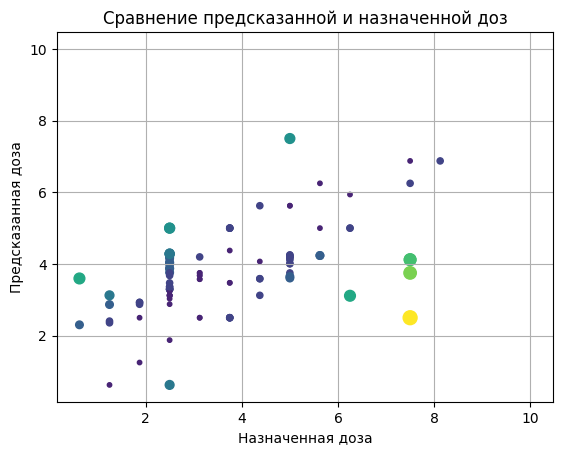

(0.4161965700299109, 0.7060478198211463, 0.6979328425964116, 15.139299153304389, 68.02721088435374)
pipeline:
from sklearn.impute import SimpleImputer
from category_encoders.target_encoder import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.kernel_approximation import Nystroem
from category_encoders.ordinal import OrdinalEncoder
from sklearn.neighbors import KNeighborsRegressor
from numpy import nan
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('ord-enc', OrdinalEncoder(cols=[], drop_invariant=True)),
('oh-enc', OneHotEncoder(cols=[])),
('target_enc', TargetEncoder(cols=[])),
('imputation', SimpleImputer(strategy='median')),
('1', Nystroem(gamma=0.15000000000000002, kernel='poly', n_components=2)),
('0', KNeighborsRegressor(n_neighbors=98, p=2, weights='distance'))])




In [14]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)  #shuffle=False, 
scores, estimator = pipe_select(train_df, test_df, BaseSearch=AsyncEA(population_size=100),
               scoring=('neg_mean_squared_error','r2'),regularize_length=True
               )
print(scores)
print(f"pipeline:\n{estimator.export_script(f'gama_short_EA{MAX_TIME}.py')}\n")


Задание завершится приблизительно через 10.0 мин.
0.9733010931073781
pipeline:
from sklearn.impute import SimpleImputer
from category_encoders.target_encoder import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.ordinal import OrdinalEncoder
from sklearn.cluster import FeatureAgglomeration
from sklearn.neighbors import KNeighborsRegressor
from numpy import nan
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('ord-enc', OrdinalEncoder(cols=[], drop_invariant=True)),
('oh-enc', OneHotEncoder(cols=[])),
('target_enc', TargetEncoder(cols=[])),
('imputation', SimpleImputer(strategy='median')),
('1', FeatureAgglomeration(affinity='euclidean', linkage='ward')),
('0', KNeighborsRegressor(n_neighbors=78, p=1, weights='distance'))])


Средняя абсолютная ошибка (MAE):                         0.44
Среднеквадратичная ошибка (MSE):                         0.97
Коэффициент детерминации (R^2):                          0.65
Средняя абсолютная процен

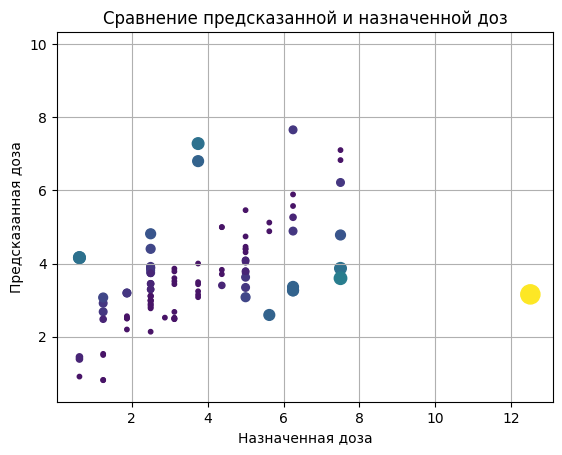

(0.44472455436171326, 0.9733010931073781, 0.649960975788035, 17.155079741649505, 72.44897959183673)
pipeline:
from sklearn.impute import SimpleImputer
from category_encoders.target_encoder import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.ordinal import OrdinalEncoder
from sklearn.cluster import FeatureAgglomeration
from sklearn.neighbors import KNeighborsRegressor
from numpy import nan
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('ord-enc', OrdinalEncoder(cols=[], drop_invariant=True)),
('oh-enc', OneHotEncoder(cols=[])),
('target_enc', TargetEncoder(cols=[])),
('imputation', SimpleImputer(strategy='median')),
('1', FeatureAgglomeration(affinity='euclidean', linkage='ward')),
('0', KNeighborsRegressor(n_neighbors=78, p=1, weights='distance'))])




In [15]:
# Со стратификацией Александра
train_df, test_df = simplified_stratified_split(df, target_column='dose', n_bins=4, 
                                                test_size=0.2, random_state=RANDOM_STATE)

scores, estimator = pipe_select(train_df, test_df, BaseSearch=AsyncEA(population_size=100),
               scoring=('neg_mean_squared_error','r2'),regularize_length=True
               )
print(scores)
print(f"pipeline:\n{estimator.export_script(f'gama_EA_S{MAX_TIME}.py')}\n")

## Подбор с AsynchronousSuccessiveHalving 


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from gama import GamaRegressor
from sklearn.model_selection import train_test_split
from gama.search_methods import AsyncEA
from gama.search_methods import AsynchronousSuccessiveHalving

In [11]:

RANDOM_STATE = 0
MAX_TIME = 600
JOBS = 4

Задание завершится приблизительно через 10.0 мин.
0.6416881976216315
pipeline:
from category_encoders.target_encoder import TargetEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from numpy import nan
from sklearn.cluster import FeatureAgglomeration
from category_encoders.one_hot import OneHotEncoder
from category_encoders.ordinal import OrdinalEncoder
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('ord-enc', OrdinalEncoder(cols=[], drop_invariant=True)),
('oh-enc', OneHotEncoder(cols=[])),
('target_enc', TargetEncoder(cols=[])),
('imputation', SimpleImputer(strategy='median')),
('1', FeatureAgglomeration(affinity='l2', linkage='complete')),
('0', KNeighborsRegressor(n_neighbors=24, p=1, weights='distance'))])


Средняя абсолютная ошибка (MAE):                         0.42
Среднеквадратичная ошибка (MSE):                         0.64
Коэффициент детерминации (R^2):                          0.73
Средняя абсолютная процентна

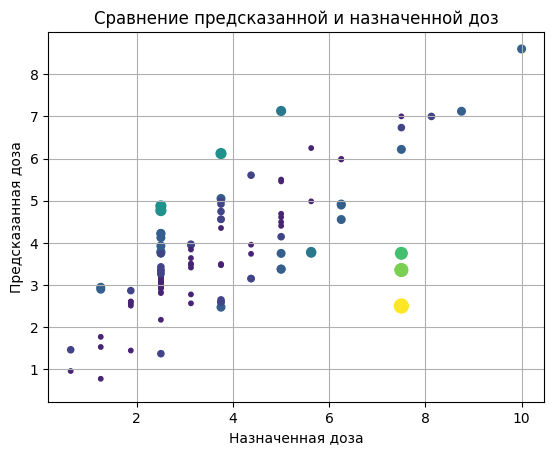

(0.41932507743189174, 0.6416881976216315, 0.7254677029608285, 13.017314580683875, 71.42857142857143)
pipeline:
from category_encoders.target_encoder import TargetEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from numpy import nan
from sklearn.cluster import FeatureAgglomeration
from category_encoders.one_hot import OneHotEncoder
from category_encoders.ordinal import OrdinalEncoder
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('ord-enc', OrdinalEncoder(cols=[], drop_invariant=True)),
('oh-enc', OneHotEncoder(cols=[])),
('target_enc', TargetEncoder(cols=[])),
('imputation', SimpleImputer(strategy='median')),
('1', FeatureAgglomeration(affinity='l2', linkage='complete')),
('0', KNeighborsRegressor(n_neighbors=24, p=1, weights='distance'))])




In [12]:
# Без стратификации
train_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)  #shuffle=False, 

scores, estimator = pipe_select(train_df, test_df, BaseSearch=AsynchronousSuccessiveHalving(),
               scoring=('neg_mean_squared_error','r2'),regularize_length=True
               )
print(scores)
print(f"pipeline:\n{estimator.export_script(f'gama_short_ASH{MAX_TIME}.py')}\n")



In [ ]:
# # Со стратификацией Александра
# train_df, test_df = simplified_stratified_split(df, target_column='dose', n_bins=4, 
#                                                 test_size=0.2, random_state=RANDOM_STATE)
# ....

## Removed Features

In [13]:
df = pd.read_excel('data_for_model.xlsx')
df = df.dropna()
# df = critical_age(df,tr_age=40)
# df['trend'] = df['INR(MHO)'] - df['prev_INR(MHO)']
df.head()

,id,age,dose,prev_INR(MHO),atrial_fibrillation,mitral_valve,aortal_valve,date_diff,INR(MHO),sample,...,institution_id_22,institution_id_23,institution_id_24,institution_id_25,institution_id_26,institution_id_27,institution_id_28,institution_id_29,institution_id_30,institution_id_31
0,140361892057136,57,7.50,3.11,1,0,0,13,3.32,1,...,0,0,0,0,0,0,0,0,0,0
1,140361892057136,57,7.50,3.32,1,0,0,15,2.01,2,...,0,0,0,0,0,0,0,0,0,0
2,140361892057264,50,5.00,2.01,0,1,0,26,2.75,1,...,0,0,0,0,0,0,0,0,0,0
3,140361892057392,53,6.25,1.42,1,0,0,15,2.56,1,...,0,0,0,0,0,0,0,0,0,0
4,140361892057392,53,6.25,2.56,1,0,0,49,2.80,2,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Несущественные признаки, удаляемые из данных: treshold = 2

features_to_remove = ['institution_id_6',
 'zodiac_Leo',
 'zodiac_Libra',
 'institution_id_28',
 'agebin_7',
 'institution_id_26',
 'zodiac_Aquarius',
 'd2',
 'critical_age_l',
 'agebin_8',
 'zodiac_Cancer',
 'institution_id_21',
 'zodiac_Pisces',
 'institution_id_16',
 'agebin_1',
 'agebin_4',
 'institution_id_12',
 'agebin_6',
 'agebin_2',
 'institution_id_10',
 'zodiac_Gemini',
 'institution_id_30',
 'institution_id_18',
 'institution_id_17',
 'institution_id_19',
 'age_percentile',
 'institution_id_14',
 'institution_id_15',
 'd3',
 'zodiac_Virgo',
 'age_level1',
 'd7',
 'zodiac_Capricorn',
 'institution_id_29',
 'zodiac_Scorpio',
 'age_level',
 'age_level3',
 'zodiac_Taurus',
 'age_quantile',
 'pass_dose',
 'age_level2',
 'zodiac_Sagittarius',
 'agebin_5',
 'is_elderly',
 'zodiac_Aries',
 'd4',
 'd6',
 'age_level6',
 'age_level5',
 'age_level4']

In [16]:
# Удаляем несущественные признаки из датасета

def remove_features(df, column_names):
    return df.drop(columns=column_names)


clear_df = remove_features(df.copy(), features_to_remove)

clear_df.head(3)

,id,age,dose,prev_INR(MHO),atrial_fibrillation,mitral_valve,aortal_valve,date_diff,INR(MHO),sample,...,institution_id_9,institution_id_11,institution_id_13,institution_id_20,institution_id_22,institution_id_23,institution_id_24,institution_id_25,institution_id_27,institution_id_31
0,140361892057136,57,7.5,3.11,1,0,0,13,3.32,1,...,0,0,0,1,0,0,0,0,0,0
1,140361892057136,57,7.5,3.32,1,0,0,15,2.01,2,...,0,0,0,1,0,0,0,0,0,0
2,140361892057264,50,5.0,2.01,0,1,0,26,2.75,1,...,0,0,0,1,0,0,0,0,0,0


In [17]:
clear_df.to_excel(f'data_for_model_few_features.xlsx', index=False)
df = pd.read_excel('data_for_model_few_features.xlsx')
df = df.dropna()
df.head(3)


,id,age,dose,prev_INR(MHO),atrial_fibrillation,mitral_valve,aortal_valve,date_diff,INR(MHO),sample,...,institution_id_9,institution_id_11,institution_id_13,institution_id_20,institution_id_22,institution_id_23,institution_id_24,institution_id_25,institution_id_27,institution_id_31
0,140361892057136,57,7.5,3.11,1,0,0,13,3.32,1,...,0,0,0,1,0,0,0,0,0,0
1,140361892057136,57,7.5,3.32,1,0,0,15,2.01,2,...,0,0,0,1,0,0,0,0,0,0
2,140361892057264,50,5.0,2.01,0,1,0,26,2.75,1,...,0,0,0,1,0,0,0,0,0,0


Задание завершится приблизительно через 10.0 мин.
0.7873776637542521
pipeline:
from category_encoders.target_encoder import TargetEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from numpy import nan
from category_encoders.one_hot import OneHotEncoder
from category_encoders.ordinal import OrdinalEncoder
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('ord-enc', OrdinalEncoder(cols=[], drop_invariant=True)),
('oh-enc', OneHotEncoder(cols=[])),
('target_enc', TargetEncoder(cols=[])),
('imputation', SimpleImputer(strategy='median')),
('1', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
('0', KNeighborsRegressor(n_neighbors=34, p=1, weights='distance'))])


Средняя абсолютная ошибка (MAE):                         0.55
Среднеквадратичная ошибка (MSE):                         0.79
Коэффициент детерминации (R^2):                          0.68
Средняя

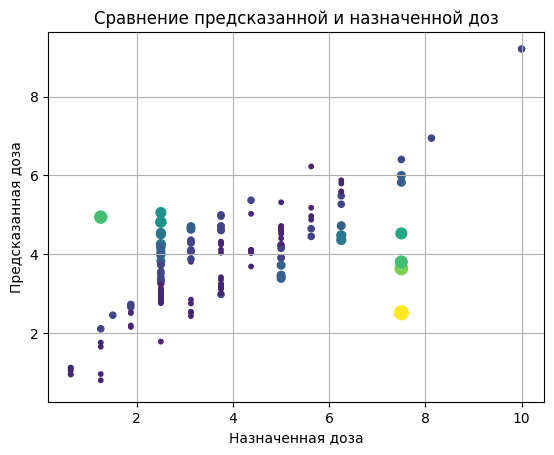

(0.5495794323697742, 0.7873776637542521, 0.6781540694108754, 18.990339081044947, 61.3013698630137)
pipeline:
from category_encoders.target_encoder import TargetEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from numpy import nan
from category_encoders.one_hot import OneHotEncoder
from category_encoders.ordinal import OrdinalEncoder
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('ord-enc', OrdinalEncoder(cols=[], drop_invariant=True)),
('oh-enc', OneHotEncoder(cols=[])),
('target_enc', TargetEncoder(cols=[])),
('imputation', SimpleImputer(strategy='median')),
('1', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
('0', KNeighborsRegressor(n_neighbors=34, p=1, weights='distance'))])




In [19]:
# Без стратификации длинные pipelines
train_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)  #shuffle=False, 

scores, estimator = pipe_select(train_df, test_df, BaseSearch=AsynchronousSuccessiveHalving(),
               scoring=('neg_mean_squared_error','r2') #,regularize_length=False
               )
print(scores)
print(f"pipeline:\n{estimator.export_script(f'gama_ASH_Clear_df{MAX_TIME}.py')}\n")
